# クラスタリング


In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [2]:
# データの準備
from sklearn import datasets
iris = datasets.load_iris()
iris_data = iris.data
iris_petal_data = iris_data[:, 2:]  # (花弁の長さ、花弁の幅)
iris_target = iris.target

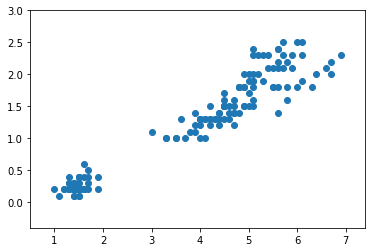

In [3]:
xlist = iris_petal_data[:,0]
ylist = iris_petal_data[:,1]
plt.scatter(xlist, ylist)
plt.xlim((min(xlist) - 0.5, max(xlist) + 0.5))
plt.ylim((min(ylist) - 0.5, max(ylist) + 0.5))
plt.show()

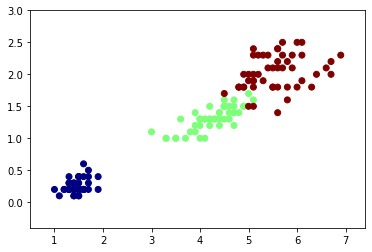

In [4]:
xlist = iris_petal_data[:,0]
ylist = iris_petal_data[:,1]
color = cm.jet(np.linspace(0, 1, 3))
colors = [color[cls] for cls in iris_target]  # クラスごとに色分け
plt.scatter(xlist, ylist, c=colors)
plt.xlim((min(xlist) - 0.5, max(xlist) + 0.5))
plt.ylim((min(ylist) - 0.5, max(ylist) + 0.5))
plt.show()

# K-means(K-平均法)

### アルゴリズム
+ 分割したいクラスタ数kを決める
+ k個の重心(centroid)を決める（ランダムに決めたりうまく分散するように選んだり）
  + （例: [k-means++](https://ja.wikipedia.org/wiki/K-means%2B%2B%E6%B3%95))
+ 各サンプル点を近い重心にわりあてる
+ わりあてたサンプル点から新しい重心を計算する
+ 上2つのステップを繰り返し、結果が変わらなくなったら終了

### 特徴
+ アルゴリズムが簡単
+ クラスタ数kは与える必要がある
+ 結果や実行時間が初期値に大きく依存する

[sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)

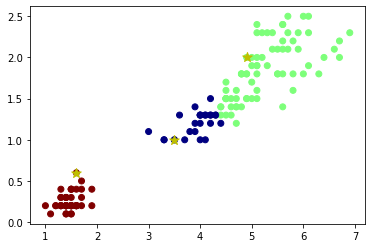

0


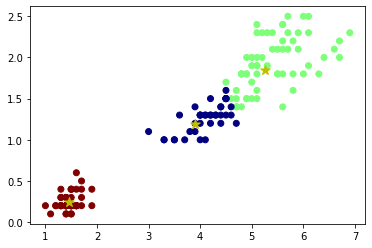

1


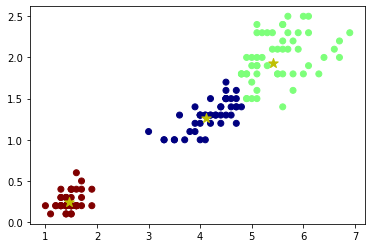

2


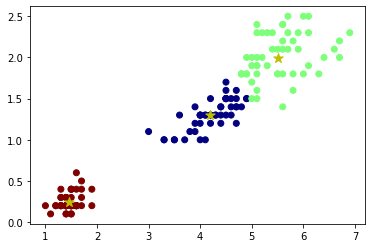

3


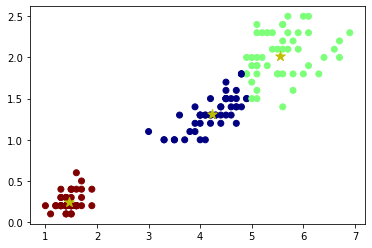

4


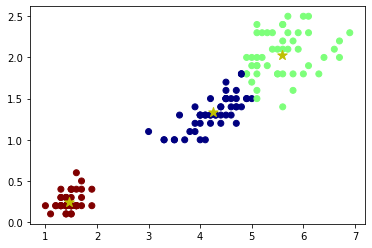

5


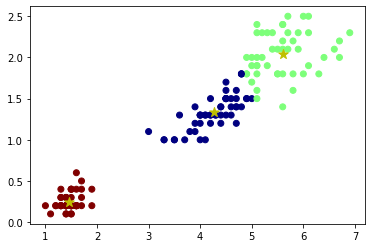

In [5]:
def plot(data, centroids, colors):
    xlist = data[:,0]
    ylist = data[:,1]
    plt.scatter(xlist, ylist, c=colors)
    plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c="y", marker="*")
    plt.show()

K = 3
# 最初の重心はデータの中からランダムに選ぶ
cent_id = np.random.choice(len(iris_petal_data), size=K, replace=False)
centroids = iris_petal_data[cent_id]
prev_classes = None
classes = np.argmin(np.linalg.norm(centroids[:, None, :] - iris_petal_data, axis=2), axis=0)

# 可視化
color = cm.jet(np.linspace(0, 1, K))
colors = [color[cls] for cls in classes]
plot(iris_petal_data, centroids, colors)

iter = 0
while prev_classes is None or np.any(prev_classes != classes):  # データの変更がなくなったら終了
    print(iter)
    for i in range(K):
        if np.count_nonzero(classes == i) > 0:
            centroids[i] = np.mean(iris_petal_data[classes == i], axis=0)  # 重心を再計算
    prev_classes = classes
    dist = np.linalg.norm(centroids[:, None, :] - iris_petal_data, axis=2)  # 各データと重心との距離を計算
    classes = np.argmin(dist, axis=0) # 各データを近い重心に割当

    # 可視化
    colors = [color[cls] for cls in classes]
    plot(iris_petal_data, centroids, colors)

    iter += 1
    if iter > 100:
        break

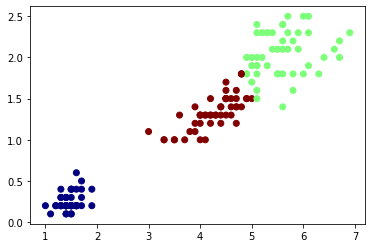

In [6]:
# scikit-learn実装
from sklearn.cluster import KMeans


K = 3
model = KMeans(n_clusters=K, random_state=0, init="k-means++")
model.fit(iris_petal_data)

# 可視化
xlist = iris_petal_data[:,0]
ylist = iris_petal_data[:,1]
color = cm.jet(np.linspace(0, 1, K))
colors = [color[cls] for cls in model.labels_]
plt.scatter(xlist, ylist, c=colors)
plt.show()

# Hierarchical clustering（階層型クラスタリング）
サンプル点やクラスタ同士を近い順にくっつけて最終的に1個のクラスタにする方法。
サンプル点がN個だった場合、一回くっつけるとN-1個のクラスタ、二回くっつけるとN-2個、... N-1回くっつけると1個のクラスタができる。

### 特徴
+ サンプル間の距離さえ定義できれば適用できる（K-meansはサンプルの平均を計算できる必要がある）
+ 結果はクラスタ同士の距離（超距離）に依存する

### 代表的な超距離
+ ward
+ avelage
+ complete
+ single

In [7]:
def clst_ward_dist(c1, c2):
    """
    c1: List(N, 2)
      N点のサンプルでできたクラスタ
    c2: List(M, 2)
      M点のサンプルでできたクラスタ
    """
    f = lambda x: np.sum(np.power(np.linalg.norm(x - np.mean(x, axis=0), axis=1), 2))  # 距離の二乗の総和
    c1_var = f(c1)
    c2_var = f(c2)
    c = np.vstack([c1, c2])
    c_var = f(c)
    return c_var - c1_var - c2_var, None, None  # 情報ロス量


def clst_average_dist(c1, c2):
    c1 = np.tile(c1[:, None, :], (1, len(c2), 1))  # len(c1)xlen(c2)x2
    c2 = np.tile(c2, (len(c1), 1, 1))  # len(c1)xlen(c2)x2
    d = np.mean(np.linalg.norm(c1 - c2, axis=2))  # len(c1)xlen(c2)個のL2距離の平均
    return d, None, None


def clst_complete_dist(c1,c2):
    c1 = np.tile(c1[:, None, :], (1, len(c2), 1))
    c2 = np.tile(c2, (len(c1), 1, 1))
    dists = np.linalg.norm(c1 - c2, axis=2)
    d = np.max(dists)  # len(c1)xlen(c2)個の距離の最大
    c1_ind, c2_ind = np.unravel_index(np.argmax(np.linalg.norm(c1 - c2, axis=2)), (3, 3))  # どの点同士で比較したか
    return d, c1_ind, c2_ind


def clst_single_dist(c1,c2):
    c1 = np.tile(c1[:, None, :], (1, len(c2), 1))
    c2 = np.tile(c2, (len(c1), 1, 1))
    dists = np.linalg.norm(c1 - c2, axis=2)
    d = np.min(dists)  # len(c1)xlen(c2)個の距離の最小
    c1_ind, c2_ind = np.unravel_index(np.argmin(np.linalg.norm(c1 - c2, axis=2)), (3, 3))
    return d, c1_ind, c2_ind

ward
	 clst0-clst1: 15.042
	 clst0-clst2: 11.417
	 clst1-clst2: 15.375
	 merge clst0 and clst2!
average
	 clst0-clst1: 3.190
	 clst0-clst2: 2.926
	 clst1-clst2: 3.324
	 merge clst0 and clst2!
complete
	 clst0-clst1: 5.025
	 clst0-clst2: 4.031
	 clst1-clst2: 4.301
	 merge clst0 and clst2!
single
	 clst0-clst1: 0.500
	 clst0-clst2: 2.000
	 clst1-clst2: 2.062
	 merge clst0 and clst1!


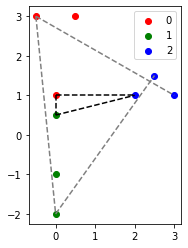

In [8]:
# 距離関数の違いの比較
from itertools import combinations

## 実験用のクラスタを３つ用意
clst0 = np.array([[0, 1], [-0.5, 3], [0.5, 3]])
clst1 = np.array([[0, 0.5], [0, -1], [0, -2]])
clst2 = np.array([[2.5, 1.5], [2, 1], [3, 1]])
clsts = [clst0, clst1, clst2]
color = ["r", "g", "b"]

plt.axes().set_aspect('equal')  # 軸のスケールをそろえる
for i in range(3):
    plt.scatter(clsts[i][:,0], clsts[i][:,1], c=color[i], label=str(i))

dist_methods = (
    ("ward", clst_ward_dist),
    ("average", clst_average_dist),
    ("complete", clst_complete_dist),
    ("single", clst_single_dist),
)

color = ["gray", "black"]
i = 0
for name, func in dist_methods:
    print(name)
    min_d = None
    merge_pair = None
    for c1, c2 in combinations([0, 1, 2], 2):
        # クラスタ間距離の計算
        d, ind1, ind2 = func(clsts[c1], clsts[c2])
        print(f"\t clst{c1}-clst{c2}: {d:.3f}")

        # 最小値更新
        if min_d is None or d < min_d:
            min_d = d
            merge_pair = (c1, c2)

        # 最小値の計算に使われた点のプロット
        if ind1 is not None and ind2 is not None:
            c1_x, c1_y = clsts[c1][ind1]
            c2_x, c2_y = clsts[c2][ind2]
            plt.plot([c1_x, c2_x], [c1_y, c2_y], c=color[i], linestyle="--")

    c1, c2 = merge_pair
    print(f"\t merge clst{c1} and clst{c2}!")
    if ind1 is not None:  # 色を切り替え
        i = (i + 1) % 2

plt.legend()  # 凡例を表示
plt.show()

+ [sklearn.cluster.AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
+ [樹形図の書き方](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py)
+ [クラスタ数の決定(Wikipedia)](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set)
  + [Elbow method(Wikipedia)](https://en.wikipedia.org/wiki/Elbow_method_(clustering))

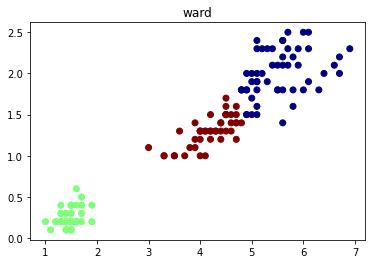

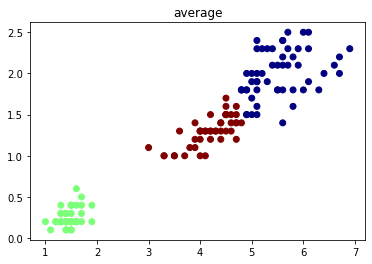

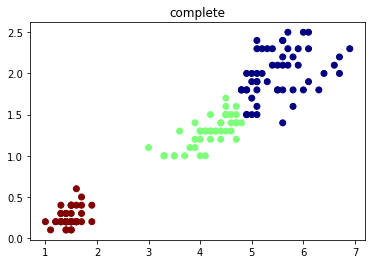

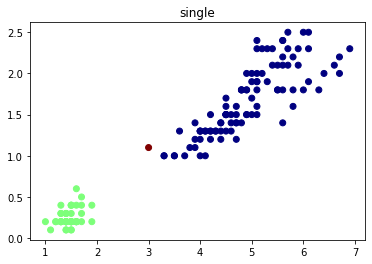

In [9]:
from sklearn.cluster import AgglomerativeClustering

for linkage in ["ward", "average", "complete", "single"]:
    model = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    model.fit(iris_petal_data)

    # 可視化
    xlist = iris_petal_data[:,0]
    ylist = iris_petal_data[:,1]
    color = cm.jet(np.linspace(0, 1, max(model.labels_) + 1))
    colors = [color[cls] for cls in model.labels_]
    plt.scatter(xlist, ylist, c=colors)
    plt.title(linkage)
    plt.show()

# 備考
[ここ](https://scikit-learn.org/stable/modules/clustering.html#clustering)に各アルゴリズムの特徴がまとめられている。

# GMM(Gaussian mixture model, 混合正規分布モデル)
各クラスタがそれぞれ異なるガウス分布から観測されたと仮定して、サンプル全体にたいしてガウス分布の線形和でフィッティングする。パラメータはクラスタ数K×2でEMアルゴリズムにより求める。

### EMアルゴリズム
以下２つのステップを繰り返す
+ Expectation
  + 現在の予測モデル（初期値はランダム）を使って、各サンプルを最大値をとるガウス分布に割り振る
+ Maximization
  + 割り振られたサンプルにたいして、最尤推定によりパラメータを求める
  
### 特徴
+ 属するクラスタを確率的に決められる

### 
+ [sklean.mixture.GassianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture)
+ [可視化のサンプル](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py)

/Users/fujino/.local/share/virtualenvs/sklean-trial-B-gOcSxw/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Log scale: values of z <= 0 have been masked


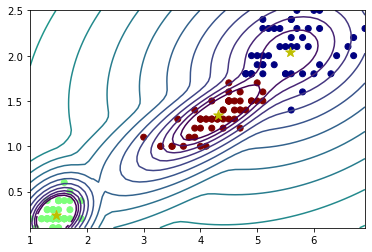

In [10]:
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

model = GaussianMixture(n_components=3)
labels = model.fit_predict(iris_petal_data)


# 可視化
xlist = iris_petal_data[:,0]
ylist = iris_petal_data[:,1]

# 等高線
x = np.linspace(np.min(xlist), np.max(xlist))
y = np.linspace(np.min(ylist), np.max(ylist))
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -model.score_samples(XX)
Z = Z.reshape(X.shape)
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 20))

# サンプル点
color = cm.jet(np.linspace(0, 1, max(labels) + 1))
colors = [color[cls] for cls in labels]
plt.scatter(xlist, ylist, c=colors)

# 平均
plt.scatter(model.means_[:, 0], model.means_[:, 1], s=100, c="y", marker="*")

plt.show()

# Mean Shift
### アルゴリズム
+ サンプル点を密度の大きい方に動かしていく、動かなくなったら終了
+ 上のステップを全サンプル点について行う
+ 最終位置がしきい値以下のサンプルを一つのクラスタにする

### 特徴
+ クラスタ数が自動で求まる

[sklearn.cluster.MeanShift](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift)

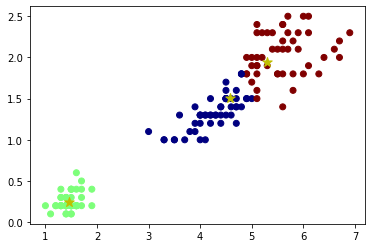

In [11]:
# scikit-learn実装
from sklearn.cluster import MeanShift


model = MeanShift()  # bandwidthがNone(default)の場合sklearn.cluster.estimate_bandwidthで推定
model.fit(iris_petal_data)

# 可視化
xlist = iris_petal_data[:,0]
ylist = iris_petal_data[:,1]
color = cm.jet(np.linspace(0, 1, np.max(model.labels_)+1))
colors = [color[cls] for cls in model.labels_]
plt.scatter(xlist, ylist, c=colors)
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=100, c="y", marker="*")
plt.show()

# DBSCAN
密度の高いサンプルをまとめてクラスタとし、密度が低いサンプルは外れ値として除く。

### 特徴
+ クラスタ数が自動で求まる
+ 外れ値を求めることができる

+ [sklearn.cluster.DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)
+ [Wikipedia](https://ja.wikipedia.org/wiki/DBSCAN)

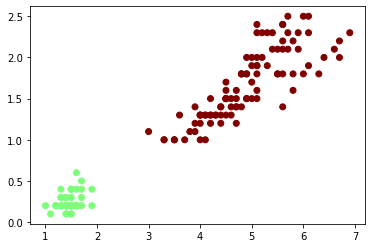

In [13]:
# scikit-learn実装
from sklearn.cluster import DBSCAN

model = DBSCAN()
model.fit(iris_petal_data)

# 可視化
xlist = iris_petal_data[:,0]
ylist = iris_petal_data[:,1]
color = cm.jet(np.linspace(0, 1, np.max(model.labels_ + 1) + 1))  # 外れ値は-1
colors = [color[cls + 1] for cls in model.labels_]
plt.scatter(xlist, ylist, c=colors)
plt.show()